In [1]:
!gpustat

ciscogpu01               Sun Jan 26 00:04:23 2025  460.106.00
[0] Tesla V100-SXM2-32GB | 40°C,   0 % |  1108 / 32510 MB | cjagad(1103M)
[1] Tesla V100-SXM2-32GB | 40°C,   0 % |  7856 / 32510 MB | cjagad(7851M)
[2] Tesla V100-SXM2-32GB | 53°C,   0 % | 12094 / 32510 MB | cjagad(2009M) cjagad(7855M) cjagad(2225M)
[3] Tesla V100-SXM2-32GB | 62°C, 100 % | 12760 / 32510 MB | yqiao(12757M)
[4] Tesla V100-SXM2-32GB | 36°C,   0 % |     3 / 32510 MB |
[5] Tesla V100-SXM2-32GB | 53°C,  28 % | 13919 / 32510 MB | cjagad(2881M) cjagad(11033M)
[6] Tesla V100-SXM2-32GB | 42°C,   0 % |  6044 / 32510 MB | cjagad(1877M) cjagad(2059M) cjagad(2103M)
[7] Tesla V100-SXM2-32GB | 52°C,  36 % |  9687 / 32510 MB | cjagad(7683M) cjagad(1999M)


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"



In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random as pyrandom
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory

import nibabel as nib
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, f1_score, precision_score, recall_score, auc, roc_auc_score
from sklearn.utils import class_weight
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score


physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2025-01-26 00:04:27.444801: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Num GPUs Available:  1


2025-01-26 00:04:38.650225: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-01-26 00:04:38.836254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-01-26 00:04:38.836316: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-01-26 00:04:38.842264: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2025-01-26 00:04:38.842368: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2025-01-26 00:04:38.847021: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

In [4]:
from tensorflow.keras import backend as K 
K.clear_session()

In [5]:
#Hyperparameter Configuration

ini_learning_rate = 1e-4
epochs = 50
early_stop = 100
seed_num = 7
drop_out = 0.5
wd = 1e-4

batch_size = 1
test_batch_size = 1

In [6]:
#Set the seed
pyrandom.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.ndimage import zoom
import os
import nibabel as nib
from sklearn.preprocessing import LabelEncoder

# Function to read and process the scans
def read_volume_file(filepath):
    """Read and load volume from .npy or .nii/.nii.gz files."""
    if filepath.endswith('.npy'):
        volume = np.load(filepath)  # Load .npy file
    elif filepath.endswith('.nii') or filepath.endswith('.nii.gz'):
        scan = nib.load(filepath)
        volume = scan.get_fdata()
    else:
        raise ValueError(f"Unsupported file type for {filepath}")
    
    return volume

def normalize(volume):
    """Normalize the volume."""
    dmin = np.amin(volume)
    dmax = np.amax(volume)
    volume = (volume - dmin) / (dmax - dmin)
    volume = volume.astype("float32")
    return volume

def resize_volume(volume, target_size=(64, 64, 64)):
    """Resize volume to the target size."""
    if len(volume.shape) != 3:
        raise ValueError(f"Unexpected volume shape: {volume.shape}. Expected 3 dimensions.")
    
    scale = [t / s for t, s in zip(target_size, volume.shape)]
    volume = zoom(volume, scale, order=1)  # Resize using linear interpolation
    return volume

def process_scan(path):
    """Read, normalize, and resize volume."""
    volume = read_volume_file(path)
    print(f"Volume shape before squeezing: {volume.shape}")  # Debugging
    volume = np.squeeze(volume)  # Remove extra dimensions
    print(f"Volume shape after squeezing: {volume.shape}")  # Debugging
    if len(volume.shape) != 3:
        raise ValueError(f"Unexpected volume shape: {volume.shape}. Expected 3 dimensions.")
    volume = normalize(volume)
    volume = resize_volume(volume)
    return volume

def train_preprocessing(x, y):
    """Preprocess training data."""
    x = tf.image.per_image_standardization(x)  # Normalize image
    return x, y

def validation_preprocessing(x, y):
    """Preprocess validation data."""
    x = tf.image.per_image_standardization(x)  # Normalize image
    return x, y

def test_preprocessing(x, y):
    """Preprocess test data."""
    x = tf.image.per_image_standardization(x)  # Normalize image
    return x, y

# Read CSV files
#train_df = pd.read_csv("/ifs/loni/faculty/thompson/four_d/rkush/Real Dataset/training.csv")
#train_df = pd.read_csv("/ifs/loni/faculty/thompson/four_d/rkush/Syn/LDM80AE2000LDM/training.csv")
#val_df = pd.read_csv("/ifs/loni/faculty/thompson/four_d/vdesai/Syn/DDPM-Conditional/testing.csv")
#val_df = pd.read_csv("/ifs/loni/faculty/thompson/four_d/rkush//Real Dataset/validation.csv")
#test_df = pd.read_csv("/ifs/loni/faculty/thompson/four_d/rkush/Real Dataset/testing.csv")

# Read CSV files
train_df = pd.read_csv("/ifs/loni/faculty/thompson/four_d/vdesai/Syn/LDM-Conditional/Real100syn200/train.csv")
val_df = pd.read_csv("/ifs/loni/faculty/thompson/four_d/vdesai/Syn/LDM-Conditional/Real100syn200/val.csv")
test_df = pd.read_csv("/ifs/loni/faculty/thompson/four_d/rkush/Real Dataset/testing.csv")
#'/ifs/loni/faculty/thompson/four_d/rkush/Syn/LDM80AE2000LDM/testing.csv'
#test_df = pd.read_csv("/ifs/loni/faculty/thompson/four_d/rkush/Real Dataset/testing.csv")

# Extract paths and labels
train_paths = train_df['Location'].tolist()
train_labels = train_df['Sex'].tolist()

val_paths = val_df['Location'].tolist()
val_labels = val_df['Sex'].tolist()

test_paths = test_df['Location'].tolist()
test_labels = test_df['Sex'].tolist()

# Process scans and convert labels to NumPy arrays
x_train = []
for path in train_paths:
    try:
        x_train.append(process_scan(path))
    except Exception as e:
        print(f"Error processing {path}: {e}")
x_train = np.array(x_train)

x_val = []
for path in val_paths:
    try:
        x_val.append(process_scan(path))
    except Exception as e:
        print(f"Error processing {path}: {e}")
x_val = np.array(x_val)

x_test = []
for path in test_paths:
    try:
        x_test.append(process_scan(path))
    except Exception as e:
        print(f"Error processing {path}: {e}")
x_test = np.array(x_test)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_val = label_encoder.transform(val_labels)
y_test = label_encoder.transform(test_labels)

# Convert to TensorFlow datasets
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Define data loaders and augment the data on the fly during training
train_dataset = (
    train_loader.shuffle(len(x_train), seed=7)
    .map(train_preprocessing)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val), seed=7)
    .map(validation_preprocessing)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_loader.map(test_preprocessing)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

# Print confirmation
print("Data loaded, reshaped, encoded, and preprocessed successfully.")
print("New shape of a single training image:", x_train[0].shape)
print("New shape of a single validation image:", x_val[0].shape)
print("New shape of a single testing image:", x_test[0].shape)


Volume shape before squeezing: (1, 1, 64, 64, 64)
Volume shape after squeezing: (64, 64, 64)
Volume shape before squeezing: (1, 1, 64, 64, 64)
Volume shape after squeezing: (64, 64, 64)
Volume shape before squeezing: (1, 1, 64, 64, 64)
Volume shape after squeezing: (64, 64, 64)
Volume shape before squeezing: (1, 1, 64, 64, 64)
Volume shape after squeezing: (64, 64, 64)
Volume shape before squeezing: (1, 1, 64, 64, 64)
Volume shape after squeezing: (64, 64, 64)
Volume shape before squeezing: (1, 1, 64, 64, 64)
Volume shape after squeezing: (64, 64, 64)
Volume shape before squeezing: (1, 1, 64, 64, 64)
Volume shape after squeezing: (64, 64, 64)
Volume shape before squeezing: (1, 1, 64, 64, 64)
Volume shape after squeezing: (64, 64, 64)
Volume shape before squeezing: (1, 1, 64, 64, 64)
Volume shape after squeezing: (64, 64, 64)
Volume shape before squeezing: (1, 1, 64, 64, 64)
Volume shape after squeezing: (64, 64, 64)
Volume shape before squeezing: (1, 1, 64, 64, 64)
Volume shape after s

2025-01-26 00:07:28.173224: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-26 00:07:28.182031: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-01-26 00:07:28.184762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2025-01-26 00:07:28.184850: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-01-26 00:07:29.200900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnec

Data loaded, reshaped, encoded, and preprocessed successfully.
New shape of a single training image: (64, 64, 64)
New shape of a single validation image: (64, 64, 64)
New shape of a single testing image: (64, 64, 64)


In [8]:
print("Number of samples for train, validation and test are %d, %d, and %d." % (x_train.shape[0], x_val.shape[0], x_test.shape[0]))

Number of samples for train, validation and test are 1284, 148, and 100.


In [9]:
print("New shape of a single training image:", x_train[0].shape)
print("New shape of a single validation image:", x_val[0].shape)
print("New shape of a single testing image:", x_test[0].shape)

New shape of a single training image: (64, 64, 64)
New shape of a single validation image: (64, 64, 64)
New shape of a single testing image: (64, 64, 64)


In [10]:
print("Shape of a single training image:", x_train[0].shape) #old 182, 218, 182
print("Shape of a single testing image:", x_test[0].shape)
print("Shape of a single validation image:", x_val[0].shape)

Shape of a single training image: (64, 64, 64)
Shape of a single testing image: (64, 64, 64)
Shape of a single validation image: (64, 64, 64)


In [11]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = pyrandom.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def test_preprocessing(volume, label):
    """Process test data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [12]:
#Define data loaders
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#Augment the data on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train), seed = seed_num)
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(batch_size)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val), seed = seed_num)
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(batch_size)
)

test_dataset = (
    test_loader.map(test_preprocessing).batch(batch_size).prefetch(batch_size)
)

2025-01-26 00:07:36.483432: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-01-26 00:07:36.484096: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2300000000 Hz


Dimension of the MRI scan is: (64, 64, 64, 1)


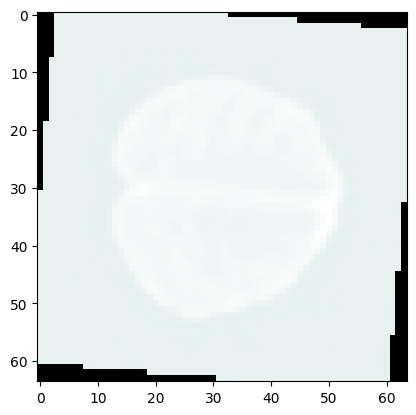

In [13]:
%matplotlib inline
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 45]), cmap="bone")

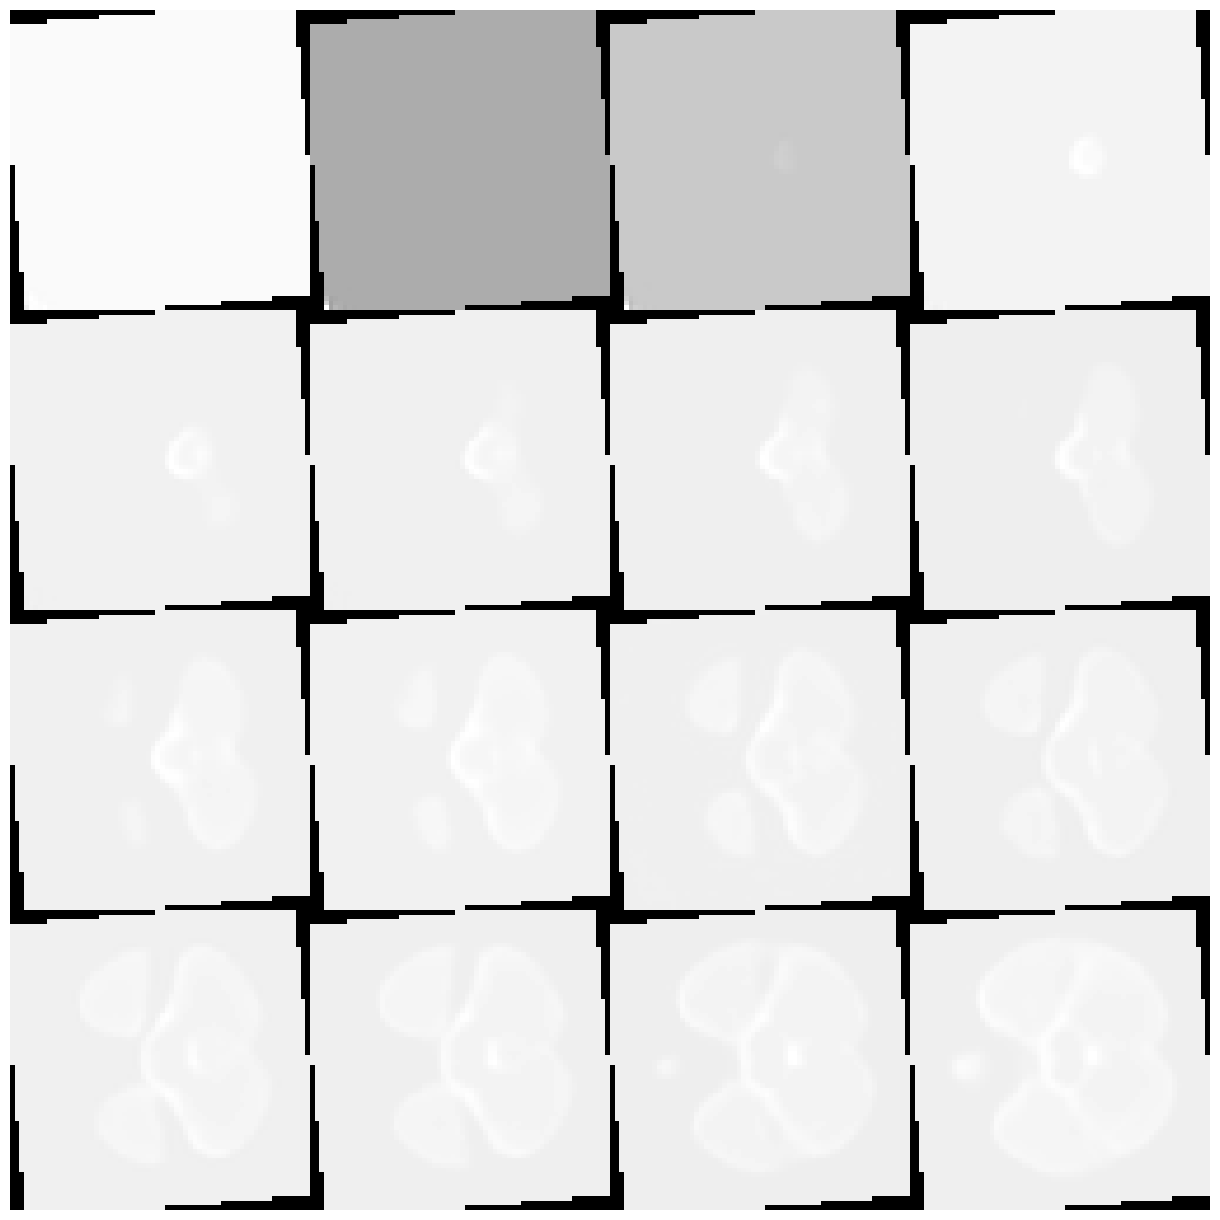

In [14]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of MRI slices."""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Adjust parameters for your 64x64x64 image
num_rows = 4
num_columns = 4
slices_to_display = num_rows * num_columns  # 16 slices
data = image[:, :, :slices_to_display]  # Extract 16 slices for the montage

# Update the width and height to match the new dimensions
plot_slices(num_rows, num_columns, 64, 64, data)


In [15]:
#try

def get_model(width=91, height=109, depth=91, drop_out=0.3):
    def convolution_block(inputs, num_filter, name):
        inputs = tf.keras.layers.Conv3D(num_filter, 3, strides=1, padding="same")(inputs)
        inputs = tfa.layers.InstanceNormalization(center=False, scale=False)(inputs)
        inputs = tf.keras.layers.MaxPooling3D(2, strides=2, padding="valid")(inputs)
        inputs = tf.nn.relu(inputs)
        return inputs

    # Input layer
    images = tf.keras.Input((width, height, depth, 1))

    # Convolution blocks
    inputs = convolution_block(images, 32, "conv_block1")  # 32x32x32x32
    inputs = convolution_block(inputs, 64, "conv_block2")  # 16x16x16x64
    inputs = convolution_block(inputs, 128, "conv_block3")  # 8x8x8x128

    # Last Conv3D layer
    inputs = tf.keras.layers.Conv3D(64, 1, strides=1, name="post_conv")(inputs)
    inputs = tfa.layers.InstanceNormalization(center=False, scale=False)(inputs)
    inputs = tf.nn.relu(inputs, name="post_relu")
    inputs = tf.keras.layers.AveragePooling3D(pool_size=(2, 2, 2), strides=2, name="post_avg_pool")(inputs)  # 4x4x4x64

    # Dropout
    inputs = tf.keras.layers.Dropout(rate=drop_out, name="drop")(inputs)

    # Flatten and Dense output
    outputs = tf.keras.layers.Flatten(name="flatten")(inputs)
    #outputs = tf.keras.layers.Dense(units=1, activation="sigmoid", name="predicted_class")(inputs)

    outputs = tf.keras.layers.Dense(units=1, activation="sigmoid", name="predicted_class")(outputs)
    


    # Define model
    model = tf.keras.Model(images, outputs, name="3dcnn")
    return model


model = get_model(width=64, height=64, depth=64)
model.summary()



Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 64, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 64, 64, 64, 32)    896       
_________________________________________________________________
instance_normalization (Inst (None, 64, 64, 64, 32)    0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 32, 32, 32, 32)    0         
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 32, 32, 32, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 32, 32, 32, 64)    55360     
_________________________________________________________________
instance_normalization_1 (In (None, 32, 32, 32, 64)    0     

In [16]:
print(next(iter(train_dataset.take(1)))[0].shape)
print(next(iter(train_dataset.take(1)))[1].shape)



(1, 64, 64, 64, 1)
(1,)


In [17]:
for batch in train_dataset.take(1):
    print(batch[0].shape)  # Inputs
    print(batch[1].shape)  # Labels


(1, 64, 64, 64, 1)
(1,)


In [18]:
#Compile model.
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    ini_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)


model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)


early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=early_stop, verbose = 1,
                                                  restore_best_weights = True)

# Train the model, doing validation at the end of each epoch

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    verbose=1,
    # callbacks=[early_stopping_cb],
)

Epoch 1/50


2025-01-26 00:07:54.022305: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2025-01-26 00:07:54.818778: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2025-01-26 00:07:56.394026: W tensorflow/core/kernels/gpu_utils.cc:69] Failed to check cudnn convolutions for out-of-bounds reads and writes with an error message: 'Failed to load in-memory CUBIN: CUDA_ERROR_INVALID_IMAGE: device kernel image is invalid'; skipping this check. This only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2025-01-26 00:07:56.415291: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2025-01-26 00:07:57.186105: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


1284/1284 [==============================] - 71s 50ms/step - loss: 0.9680 - accuracy: 0.5195 - val_loss: 1.1164 - val_accuracy: 0.5068
Epoch 2/50
1284/1284 [==============================] - 66s 50ms/step - loss: 0.9628 - accuracy: 0.5234 - val_loss: 0.9125 - val_accuracy: 0.5811
Epoch 3/50
1284/1284 [==============================] - 64s 48ms/step - loss: 0.8876 - accuracy: 0.5265 - val_loss: 0.7217 - val_accuracy: 0.6351
Epoch 4/50
1284/1284 [==============================] - 63s 48ms/step - loss: 0.8129 - accuracy: 0.5654 - val_loss: 0.5954 - val_accuracy: 0.6959
Epoch 5/50
1284/1284 [==============================] - 66s 50ms/step - loss: 0.7758 - accuracy: 0.5997 - val_loss: 0.6596 - val_accuracy: 0.5676
Epoch 6/50
1284/1284 [==============================] - 65s 50ms/step - loss: 0.7449 - accuracy: 0.6160 - val_loss: 0.6542 - val_accuracy: 0.5811
Epoch 7/50
1284/1284 [==============================] - 65s 49ms/step - loss: 0.7276 - accuracy: 0.6324 - val_loss: 0.7973 - val_accura

In [19]:
model.save("/ifs/loni/faculty/thompson/four_d/vdesai/Densenet/LDM-Conditional/200real100syn vs real/200real100syn vs real")

2025-01-26 01:00:17.167944: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /ifs/loni/faculty/thompson/four_d/vdesai/Densenet/LDM-Conditional/200real100syn vs real/200real100syn vs real/assets


In [20]:
model.save_weights(filepath='/ifs/loni/faculty/thompson/four_d/vdesai/Densenet/LDM-Conditional/200real100syn vs real/200real100syn vs real weights.h5')

CAE Training


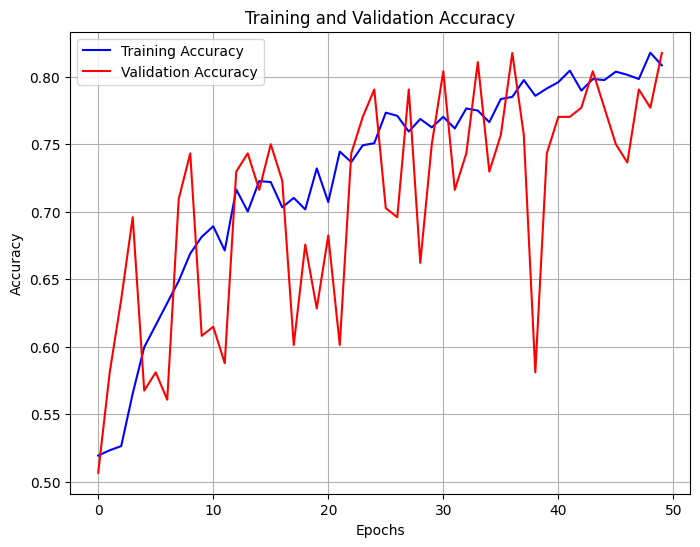

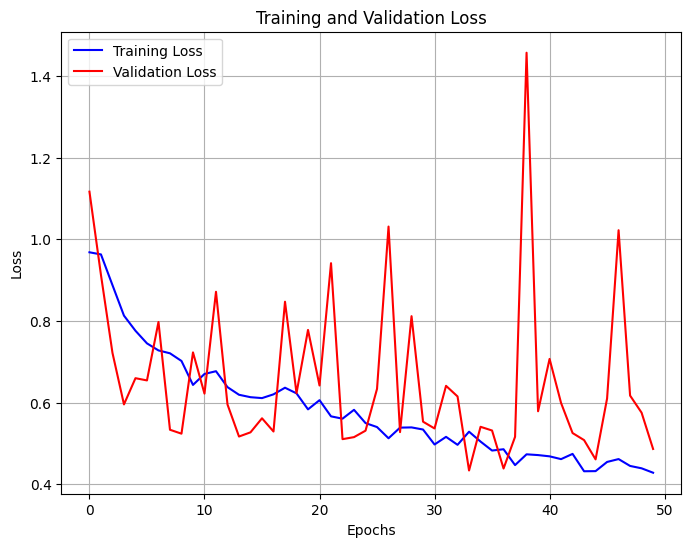

In [21]:
import matplotlib.pyplot as plt

# Print training status
print('CAE Training')

# Replace 'acc' and 'val_acc' with 'accuracy' and 'val_accuracy' for recent Keras versions
# Ensure history is defined as the output of model.fit()
acc = history.history.get('accuracy', history.history.get('acc', []))  # Fallback to 'acc' if 'accuracy' is not available
val_acc = history.history.get('val_accuracy', history.history.get('val_acc', []))  # Same for validation accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']

# Ensure accuracy and validation accuracy are available
if not acc or not val_acc:
    print("Accuracy data not found in history. Please verify the metrics used during model training.")

# Epoch range
epo = range(len(acc))

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epo, acc, 'b', label='Training Accuracy')
plt.plot(epo, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epo, loss, 'b', label='Training Loss')
plt.plot(epo, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# Testing the model on test dataset

y_pred = model.predict(test_dataset, verbose=1, steps=None, max_queue_size=test_batch_size)

fpr_tf, tpr_tf, thresholds_tf = roc_curve(y_test, y_pred)

#acc_test = accuracy_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred)
#prec = precision_score(y_test, y_pred)
#rec = recall_score(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('MSE: ', mse)
print('MAE: ', mae)

100/100 [==============================] - 1s 5ms/step
MSE:  0.1771415274492324
MAE:  0.20793823914959525


In [23]:
Y_Pred = []
for x in y_pred:
    if x > 0.5:
        Y_Pred.append(1)
    else:
        Y_Pred.append(0)
#print(Y_Pred)

In [24]:
MSE = mean_squared_error(y_test, Y_Pred)
MAE = mean_absolute_error(y_test, Y_Pred)

print('MAE: ', MAE)

MAE:  0.22


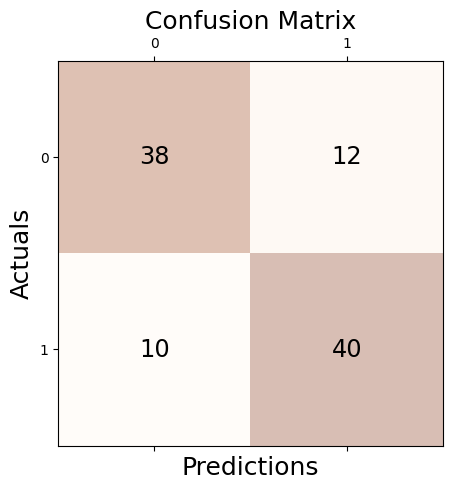

In [25]:
# Calculate the confusion matrix

conf_matrix = confusion_matrix(y_true=y_test, y_pred=Y_Pred)

# Print the confusion matrix using Matplotlib
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [26]:
print('Precision: %.3f' % precision_score(y_test, Y_Pred))
print('Recall: %.3f' % recall_score(y_test, Y_Pred))
print('Accuracy: %.3f' % accuracy_score(y_test, Y_Pred))
print('F1 Score: %.3f' % f1_score(y_test, Y_Pred))

Precision: 0.769
Recall: 0.800
Accuracy: 0.780
F1 Score: 0.784


In [27]:
print('Accuracy: %.3f' % balanced_accuracy_score(y_test, Y_Pred))

Accuracy: 0.780


In [28]:
!gpustat

ciscogpu01               Sun Jan 26 01:00:22 2025  460.106.00
[0] Tesla V100-SXM2-32GB | 41°C,   0 % |  1108 / 32510 MB | cjagad(1103M)
[1] Tesla V100-SXM2-32GB | 42°C,   0 % |  7856 / 32510 MB | cjagad(7851M)
[2] Tesla V100-SXM2-32GB | 64°C,  75 % | 13791 / 32510 MB | cjagad(2009M) cjagad(7855M) cjagad(2225M) vdesai(1697M)
[3] Tesla V100-SXM2-32GB | 65°C,  81 % | 12760 / 32510 MB | yqiao(12757M)
[4] Tesla V100-SXM2-32GB | 38°C,   0 % |     3 / 32510 MB |
[5] Tesla V100-SXM2-32GB | 55°C,   0 % | 13919 / 32510 MB | cjagad(2881M) cjagad(11033M)
[6] Tesla V100-SXM2-32GB | 46°C,   0 % |  7741 / 32510 MB | cjagad(1877M) cjagad(2059M) cjagad(2103M) vdesai(1697M)
[7] Tesla V100-SXM2-32GB | 54°C,   0 % |  9687 / 32510 MB | cjagad(7683M) cjagad(1999M)
